In [ ]:
#打印曲线

In [1]:
# Cell 1: 设置模型路径和参数 (Jupyter Notebook专用)

import os
import logging

# 日志设置 (确保在 Jupyter 中正常工作)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 定义您训练模型时使用的 output_dir
# 确保这个路径和您在命令行运行 hate_speech_trainer.py 时 --output_dir 参数的值一致
output_dir = "./results_quad_extraction_epoch23_bs16_resume/checkpoint-3500"

# 如果您的训练脚本中数据路径是 train.json，并且它在当前 Jupyter 环境可访问
data_file_path = "train.json"

# 定义训练时使用的其他重要参数，这些参数在评估时也需要
# 它们应该与您在 hate_speech_trainer.py 中设置的默认值或命令行参数一致
max_input_length = 128
max_target_length = 64
val_size = 0.1 # 用于分割验证集，虽然不重新训练，但为了数据加载一致性保留

# 确保 output_dir 存在
if not os.path.exists(output_dir):
    print(f"警告: 输出目录 '{output_dir}' 不存在。请检查路径或确保训练已完成。")
else:
    print(f"已设置模型输出目录为: {output_dir}")

# 这里不再需要导入和运行 hate_speech_trainer.py 的 main 函数
# 也不需要定义 Args 类和调用 run_training_main(args)
# 因为训练是在命令行完成的。

已设置模型输出目录为: ./results_quad_extraction_epoch23_bs16_resume/checkpoint-3500


In [ ]:
#测试评估

In [3]:
# In a new Cell after running Cell 1 and Cell 2
import json
import os
import glob

output_dir = "./results_quad_extraction_epoch10_bs16" # Make sure this variable is available

all_log_history = []
main_trainer_state_path = os.path.join(output_dir, "trainer_state.json")
if os.path.exists(main_trainer_state_path):
    try:
        with open(main_trainer_state_path, 'r', encoding='utf-8') as f:
            state = json.load(f)
            all_log_history.extend(state.get("log_history", []))
        print(f"从主目录加载 trainer_state.json: {main_trainer_state_path}")
    except json.JSONDecodeError as e:
        print(f"警告: 主目录的 trainer_state.json 文件解析失败: {e}")

checkpoint_state_files = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*", "trainer_state.json")))
for f_path in checkpoint_state_files:
    try:
        with open(f_path, 'r', encoding='utf-8') as f:
            state = json.load(f)
            current_log_history = state.get("log_history", [])

            # More robust merging: keep track of steps for both 'loss' and 'eval_loss' types of entries
            existing_steps_loss = {entry.get("step") for entry in all_log_history if "step" in entry and "loss" in entry}
            existing_steps_eval_loss = {entry.get("step") for entry in all_log_history if "step" in entry and "eval_loss" in entry}

            for entry in current_log_history:
                step = entry.get("step")
                if step is None:
                    continue # Skip entries without a step

                if "loss" in entry and step not in existing_steps_loss:
                    all_log_history.append(entry)
                    existing_steps_loss.add(step)
                elif "eval_loss" in entry and step not in existing_steps_eval_loss:
                    all_log_history.append(entry)
                    existing_steps_eval_loss.add(step)

            print(f"从检查点目录加载 trainer_state.json: {f_path}")
    except json.JSONDecodeError as e:
        print(f"警告: 检查点目录 '{f_path}' 的 trainer_state.json 文件解析失败: {e}")
    except Exception as e:
        print(f"加载 {f_path} 时发生未知错误: {e}")

all_log_history = sorted(all_log_history, key=lambda x: x.get("step", 0))

print("\n合并后的 all_log_history (前20个条目):")
for i, entry in enumerate(all_log_history[:20]): # Increased to 20 to see more
    print(f"Entry {i+1}: {entry}")

print("\n合并后的 all_log_history (后20个条目):")
for i, entry in enumerate(all_log_history[-20:]): # Increased to 20
    print(f"Entry {i+1}: {entry}")

# Check eval_loss's presence
eval_losses_found = [entry for entry in all_log_history if "eval_loss" in entry]
print(f"\n找到的包含 'eval_loss' 的条目数量: {len(eval_losses_found)}")
if eval_losses_found:
    print("其中一个包含 'eval_loss' 的条目示例:")
    print(eval_losses_found[0])
    print("所有找到的 eval_loss entries:")
    for entry in eval_losses_found:
        print(f"Step: {entry['step']}, Eval Loss: {entry['eval_loss']:.4f}")

从检查点目录加载 trainer_state.json: ./results_quad_extraction_epoch10_bs16/checkpoint-2000/trainer_state.json
从检查点目录加载 trainer_state.json: ./results_quad_extraction_epoch10_bs16/checkpoint-500/trainer_state.json

合并后的 all_log_history (前20个条目):
Entry 1: {'epoch': 0.44, 'learning_rate': 4.7777777777777784e-05, 'loss': 1.2244, 'step': 100}
Entry 2: {'epoch': 0.89, 'learning_rate': 4.555555555555556e-05, 'loss': 0.5026, 'step': 200}
Entry 3: {'epoch': 1.33, 'learning_rate': 4.3333333333333334e-05, 'loss': 0.3531, 'step': 300}
Entry 4: {'epoch': 1.78, 'learning_rate': 4.111111111111111e-05, 'loss': 0.3085, 'step': 400}
Entry 5: {'epoch': 2.22, 'learning_rate': 3.888888888888889e-05, 'loss': 0.2718, 'step': 500}
Entry 6: {'epoch': 2.22, 'eval_loss': 0.341913104057312, 'eval_runtime': 4.1326, 'eval_samples_per_second': 96.792, 'eval_steps_per_second': 24.198, 'step': 500}
Entry 7: {'epoch': 2.67, 'learning_rate': 3.6666666666666666e-05, 'loss': 0.2112, 'step': 600}
Entry 8: {'epoch': 3.11, 'learning

从检查点目录加载 trainer_state.json: ./results_quad_extraction_epoch10_bs16/checkpoint-2000/trainer_state.json
从检查点目录加载 trainer_state.json: ./results_quad_extraction_epoch10_bs16/checkpoint-500/trainer_state.json
已找到 4 个评估损失数据点。


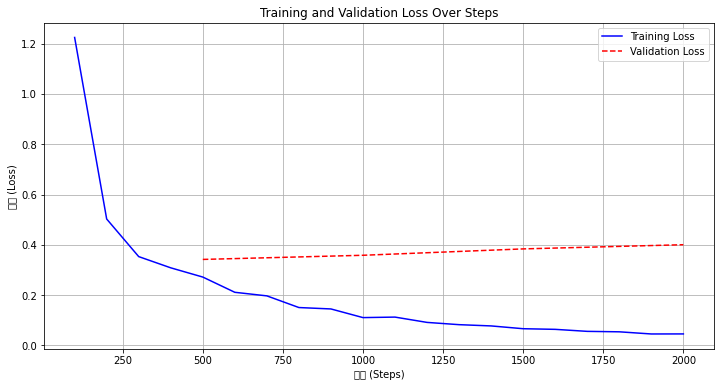


每个评估步的验证损失:
步数 500: 损失 = 0.3419
步数 1000: 损失 = 0.3584
步数 1500: 损失 = 0.3837
步数 2000: 损失 = 0.4004

已记录步数的训练损失:
步数 100: 损失 = 1.2244
步数 200: 损失 = 0.5026
步数 300: 损失 = 0.3531
步数 400: 损失 = 0.3085
步数 500: 损失 = 0.2718
步数 600: 损失 = 0.2112
步数 700: 损失 = 0.1970
步数 800: 损失 = 0.1506
步数 900: 损失 = 0.1450
步数 1000: 损失 = 0.1106
步数 1100: 损失 = 0.1126
步数 1200: 损失 = 0.0915
步数 1300: 损失 = 0.0825
步数 1400: 损失 = 0.0775
步数 1500: 损失 = 0.0664
步数 1600: 损失 = 0.0639
步数 1700: 损失 = 0.0559
步数 1800: 损失 = 0.0541
步数 1900: 损失 = 0.0455
步数 2000: 损失 = 0.0457


In [4]:
# Cell 2: 绘制损失曲线

import json
import matplotlib.pyplot as plt
import os
import glob # 导入 glob 模块用于查找文件

def plot_training_metrics(output_dir):
    """
    从 output_dir 或其子检查点目录中的 trainer_state.json 文件中加载训练日志并绘制损失曲线。
    """
    all_log_history_raw = [] # 用于存储所有原始的日志条目，包括重复和不同类型
    
    # 1. 尝试从主 output_dir 查找 trainer_state.json
    main_trainer_state_path = os.path.join(output_dir, "trainer_state.json")
    if os.path.exists(main_trainer_state_path):
        try:
            with open(main_trainer_state_path, 'r', encoding='utf-8') as f:
                state = json.load(f)
                all_log_history_raw.extend(state.get("log_history", []))
            print(f"从主目录加载 trainer_state.json: {main_trainer_state_path}")
        except json.JSONDecodeError as e:
            print(f"警告: 主目录的 trainer_state.json 文件解析失败: {e}")

    # 2. 查找所有 checkpoint-XXXX 目录下的 trainer_state.json
    checkpoint_state_files = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*", "trainer_state.json")))
    
    if not checkpoint_state_files and not all_log_history_raw: # 如果主目录和检查点目录都没有找到
        print(f"错误: 在 '{output_dir}' 及其检查点子目录中找不到 trainer_state.json 文件。")
        alternative_path = os.path.join(output_dir, "training_args.json")
        if os.path.exists(alternative_path):
            print(f"提示: 找到了 {alternative_path} 但它通常不包含详细训练日志。请确认 trainer_state.json 文件是否存在。")
        return

    for f_path in checkpoint_state_files:
        try:
            with open(f_path, 'r', encoding='utf-8') as f:
                state = json.load(f)
                all_log_history_raw.extend(state.get("log_history", [])) # 直接添加所有日志，稍后统一去重
            print(f"从检查点目录加载 trainer_state.json: {f_path}")
        except json.JSONDecodeError as e:
            print(f"警告: 检查点目录 '{f_path}' 的 trainer_state.json 文件解析失败: {e}")
        except Exception as e:
            print(f"加载 {f_path} 时发生未知错误: {e}")

    # --- 改进的去重和合并逻辑 ---
    # 使用字典来存储每个step的训练和评估日志，以便合并
    merged_log_entries = {} # Key: step, Value: merged_dict_for_that_step

    for entry in all_log_history_raw:
        step = entry.get("step")
        if step is None:
            continue # 跳过没有step的条目

        if step not in merged_log_entries:
            merged_log_entries[step] = {} # 初始化该step的合并字典

        # 合并当前条目的键值对到该step的字典中
        # 如果有重复的键，后面的会覆盖前面的，但这里我们希望合并不同的日志类型
        merged_log_entries[step].update(entry)

    # 将合并后的字典转换为列表，并按step排序
    all_log_history = sorted(list(merged_log_entries.values()), key=lambda x: x.get("step", 0))

    # --- 提取训练和验证损失 ---
    train_steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []

    for entry in all_log_history:
        if "loss" in entry: # 训练损失
            train_steps.append(entry["step"])
            train_losses.append(entry["loss"])
        if "eval_loss" in entry: # 验证损失
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])
    
    if not train_steps and not eval_steps:
        print("在 log_history 中未找到训练或评估损失数据。")
        return
    
    # 明确提示是否找到了评估损失数据
    if not eval_steps:
        print("在 log_history 中未找到评估损失数据。无法绘制验证损失曲线。")
    else:
        print(f"已找到 {len(eval_steps)} 个评估损失数据点。")


    plt.figure(figsize=(12, 6))

    if train_steps:
        plt.plot(train_steps, train_losses, label='Training Loss', color='blue')
    if eval_steps:
        plt.plot(eval_steps, eval_losses, label='Validation Loss', color='red', linestyle='--')

    plt.xlabel("步数 (Steps)")
    plt.ylabel("损失 (Loss)")
    plt.title("Training and Validation Loss Over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印详细损失信息
    if eval_steps:
        print("\n每个评估步的验证损失:")
        for step, loss in zip(eval_steps, eval_losses):
            print(f"步数 {step}: 损失 = {loss:.4f}")
    
    print("\n已记录步数的训练损失:")
    for step, loss in zip(train_steps, train_losses):
        # 动态调整打印频率，避免过长输出
        if len(train_steps) > 50 and step % (max(1, len(train_steps) // 50)) == 0:
             print(f"步数 {step}: 损失 = {loss:.4f}")
        elif len(train_steps) <= 50:
            print(f"步数 {step}: 损失 = {loss:.4f}")

# 调用函数，使用 Cell 1 中定义的 output_dir
if 'output_dir' in globals(): # 检查 output_dir 是否已定义
    plot_training_metrics(output_dir)
else:
    print("错误: 'output_dir' 变量未定义。请先运行 Jupyter Notebook 的 Cell 1。")

2025-06-14 00:00:19,291 - INFO - 正在从 ./results_quad_extraction_f1_optimized_bs16_eval32/checkpoint-2200 加载分词器和模型...
2025-06-14 00:00:22,350 - INFO - 正在重新加载并分割验证集数据...
2025-06-14 00:00:22,351 - INFO - 正在从 train.json 加载数据...
2025-06-14 00:00:22,364 - INFO - 已加载 4000 条样本。
2025-06-14 00:00:22,365 - INFO - 示例处理后的文本: 没爹的黑孩到处扔
2025-06-14 00:00:22,366 - INFO - 示例处理后的目标字符串: 没爹的黑孩 | 到处扔 | Racism | hate [END]
2025-06-14 00:00:22,390 - INFO - 已加载 400 条验证样本。
2025-06-14 00:00:22,533 - INFO - 正在验证集上生成预测...
2025-06-14 00:01:48,162 - INFO - 已处理 100 批次预测。



--- 评估结果 ---
硬匹配 F1-score: 精确率=0.1551, 召回率=0.1656, F1=0.1602
软匹配 F1-score: 精确率=0.3419, 召回率=0.3652, F1=0.3532

--- 预测样本与真实标签对比 (前5个样本) ---

原始文本: 看到“我是男的”，100%是女拳，毕竟有句话说自己没什么就喜欢强调什么
真实标签: 女拳 | 自己没什么就喜欢强调什么 | Sexism | hate [END]
预测结果: 女拳 | 100%是女拳 | Sexism | hate [END]
------------------------------------------------------------

原始文本: 是呗，正常女哪有喜欢黑人的啊😅
真实标签: 黑人 | 正常女哪有喜欢黑人的啊😅 | Racism | hate [END]
预测结果: 黑人 | 正常女哪有喜欢黑人的啊 | Racism | hate [END]
------------------------------------------------------------

原始文本: 请问有没有3个女同在一起的？我看片有，现实世界有3个女的在一起？
真实标签: 3个女同 | 在一起 | LGBTQ | hate [END]
预测结果: NULL | 现实世界有3个女的在一起的 | Sexism | hate [END]
------------------------------------------------------------

原始文本: 好像很多中国男人找黑妹啊，抖音上一大把，非洲黑黄混血的孩子都数不清
真实标签: 中国男人 | 找黑妹 | Sexism, Racism | hate [SEP] 黑黄混血 | 数不清 | Racism | hate [END]
预测结果: 很多中国男人 | 找黑妹 | Sexism, Racism | hate [SEP] 非洲黑黄混血的孩子 | 数不清 | Region | hate [END]
------------------------------------------------------------

原始文本: 《西瓜汁分尼一半》怎么唱来着
真实标签: 尼 | 《西瓜汁分尼

/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3476/3677325082.py:205: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.
  fig.

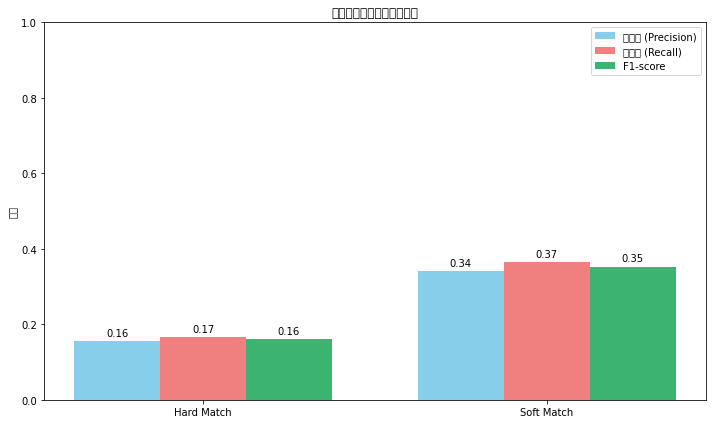

In [7]:
# Cell 3: 验证集上的测试与F1分数计算

import json
import os
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from difflib import SequenceMatcher # 字符串相似度匹配需要
import matplotlib.pyplot as plt # 用于绘制F1曲线
import numpy as np
import logging

# 从 hate_speech_trainer.py 导入必要的组件
from hate_speech_trainer import (
    HateSpeechQuadrupletDataset,
    load_and_preprocess_data, # <--- **重新导入这个函数！**
    format_quadruplet_to_string,
    create_target_string,
    VALID_TARGETED_GROUPS,
    TARGETED_GROUP_MAPPING,
    logger
)

# 日志设置 (如果这是独立脚本，需要重新设置)
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

# --- 辅助函数：将生成的字符串解析回四元组 --- (这些函数保持不变)
def parse_quadruplet_string(quad_str):
    if not quad_str or not quad_str.strip():
        return None
    quad_str = quad_str.replace(" [END]", "").strip()
    parts = quad_str.split(" | ")
    if len(parts) != 4:
        return {"target": None, "argument": None, "targeted_group": "non-hate", "hateful": "non-hate"}
    return {
        "target": parts[0] if parts[0] != "NULL" else None,
        "argument": parts[1] if parts[1] != "NULL" else None,
        "targeted_group": parts[2],
        "hateful": parts[3]
    }

def parse_target_string_to_quadruplets(full_target_string):
    if not full_target_string or not full_target_string.strip():
        return []
    if full_target_string.endswith(" [SEP]"):
        full_target_string = full_target_string[:-len(" [SEP]")]
    quad_strings = full_target_string.split(" [SEP] ")
    quadruplets = [parse_quadruplet_string(qs) for qs in quad_strings]
    return [q for q in quadruplets if q is not None]

# --- 自定义F1分数计算函数 --- (这些函数保持不变)
def calculate_similarity(s1, s2):
    if s1 is None: s1 = ""
    if s2 is None: s2 = ""
    if not s1 and not s2:
        return 1.0
    if not s1 or not s2:
        return 0.0
    s = SequenceMatcher(None, s1, s2)
    return s.ratio()

def is_hard_match(pred_quad, gold_quad):
    if pred_quad is None or gold_quad is None: return False
    return (pred_quad["target"] == gold_quad["target"] and
            pred_quad["argument"] == gold_quad["argument"] and
            pred_quad["targeted_group"] == gold_quad["targeted_group"] and
            pred_quad["hateful"] == gold_quad["hateful"])

def is_soft_match(pred_quad, gold_quad, similarity_threshold=0.5):
    if pred_quad is None or gold_quad is None: return False
    pred_targeted_group = TARGETED_GROUP_MAPPING.get(pred_quad.get("targeted_group"), pred_quad.get("targeted_group"))
    gold_targeted_group = TARGETED_GROUP_MAPPING.get(gold_quad.get("targeted_group"), gold_quad.get("targeted_group"))
    if pred_targeted_group not in VALID_TARGETED_GROUPS:
        pred_targeted_group = 'others'
    if gold_targeted_group not in VALID_TARGETED_GROUPS:
        gold_targeted_group = 'others'
    if not (pred_targeted_group == gold_targeted_group and
            pred_quad["hateful"] == gold_quad["hateful"]):
        return False
    target_sim = calculate_similarity(pred_quad["target"], gold_quad["target"])
    argument_sim = calculate_similarity(pred_quad["argument"], gold_quad["argument"])
    return target_sim >= similarity_threshold and argument_sim >= similarity_threshold

def calculate_f1_score(predictions_list_of_lists, references_list_of_lists, match_type='hard'):
    total_true_positives = 0
    total_predicted_quads = 0
    total_ground_truth_quads = 0
    for i in range(len(predictions_list_of_lists)):
        pred_list = predictions_list_of_lists[i]
        gold_list = references_list_of_lists[i]
        total_predicted_quads += len(pred_list)
        total_ground_truth_quads += len(gold_list)
        matched_gold_indices = set()
        for pred_quad in pred_list:
            is_matched_in_this_sample = False
            for g_idx, gold_quad in enumerate(gold_list):
                if g_idx in matched_gold_indices:
                    continue
                if match_type == 'hard' and is_hard_match(pred_quad, gold_quad):
                    total_true_positives += 1
                    matched_gold_indices.add(g_idx)
                    is_matched_in_this_sample = True
                    break
                elif match_type == 'soft' and is_soft_match(pred_quad, gold_quad):
                    total_true_positives += 1
                    matched_gold_indices.add(g_idx)
                    is_matched_in_this_sample = True
                    break
    precision = total_true_positives / total_predicted_quads if total_predicted_quads > 0 else 0
    recall = total_true_positives / total_ground_truth_quads if total_ground_truth_quads > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {"precision": precision, "recall": recall, "f1": f1}

# --- 主要评估逻辑 ---
def evaluate_model_on_validation_set_jupyter(tokenizer, model, val_texts, val_labels, max_input_length, max_target_length):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    predicted_quadruplets_lists = []
    gold_quadruplets_lists = []

    logger.info("正在验证集上生成预测...")

    temp_val_dataset = HateSpeechQuadrupletDataset(val_texts, val_labels, tokenizer, max_input_length, max_target_length)
    batch_size = 4
    dataloader = DataLoader(temp_val_dataset, batch_size=batch_size, shuffle=False)

    predicted_strings_total = []

    for batch_idx, batch in enumerate(dataloader):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        
        with torch.no_grad():
            generated_ids = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_target_length,
                num_beams=4,
                early_stopping=True,
                do_sample=False
            )

        predicted_strings_batch = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        gold_strings_batch = [tokenizer.decode(ids[ids != -100], skip_special_tokens=True) for ids in batch['labels']]

        predicted_strings_total.extend(predicted_strings_batch)

        for pred_str, gold_str in zip(predicted_strings_batch, gold_strings_batch):
            predicted_quadruplets_lists.append(parse_target_string_to_quadruplets(pred_str))
            gold_quadruplets_lists.append(parse_target_string_to_quadruplets(gold_str))

        if (batch_idx + 1) % 100 == 0:
            logger.info(f"已处理 {batch_idx + 1} 批次预测。")

    hard_f1_results = calculate_f1_score(predicted_quadruplets_lists, gold_quadruplets_lists, match_type='hard')
    soft_f1_results = calculate_f1_score(predicted_quadruplets_lists, gold_quadruplets_lists, match_type='soft')

    print("\n--- 评估结果 ---")
    print(f"硬匹配 F1-score: 精确率={hard_f1_results['precision']:.4f}, 召回率={hard_f1_results['recall']:.4f}, F1={hard_f1_results['f1']:.4f}")
    print(f"软匹配 F1-score: 精确率={soft_f1_results['precision']:.4f}, 召回率={soft_f1_results['recall']:.4f}, F1={soft_f1_results['f1']:.4f}")

    print("\n--- 预测样本与真实标签对比 (前5个样本) ---")
    for i in range(min(5, len(val_texts))):
        print(f"\n原始文本: {val_texts[i]}")
        print(f"真实标签: {val_labels[i]}")
        print(f"预测结果: {predicted_strings_total[i]}")
        print("-" * 60)

    labels = ['Hard Match', 'Soft Match']
    precision_values = [hard_f1_results['precision'], soft_f1_results['precision']]
    recall_values = [hard_f1_results['recall'], soft_f1_results['recall']]
    f1_values = [hard_f1_results['f1'], soft_f1_results['f1']]

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, precision_values, width, label='精确率 (Precision)', color='skyblue')
    rects2 = ax.bar(x, recall_values, width, label='召回率 (Recall)', color='lightcoral')
    rects3 = ax.bar(x + width, f1_values, width, label='F1-score', color='mediumseagreen')

    ax.set_ylabel('分数')
    ax.set_title('模型在验证集上的评估指标')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 1)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


# --- 如何运行评估 ---
# 确保这些变量在 Cell 1 运行后已被定义
# output_dir, data_file_path, max_input_length, max_target_length, val_size

# 1. 检查 output_dir 是否已定义
if 'output_dir' not in globals():
    print("错误: 'output_dir' 变量未定义。请先运行 Jupyter Notebook 的 Cell 1。")
else:
    # 2. 加载训练好的模型和分词器
    logging.info(f"正在从 {output_dir} 加载分词器和模型...")
    tokenizer = AutoTokenizer.from_pretrained(output_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained(output_dir)

    # 3. 重新加载并分割验证集数据
    # 因为 val_texts_raw 和 val_labels_raw 在命令行训练后不会自动在 Jupyter 中
    # 而且它们是评估函数所需要的原始文本和标签
    logging.info("正在重新加载并分割验证集数据...")
    _, _, val_texts_raw, val_labels_raw = load_and_preprocess_data(
        data_file_path, tokenizer, max_input_length, max_target_length, val_size
    )
    logging.info(f"已加载 {len(val_texts_raw)} 条验证样本。")

    # 4. 调用评估函数
    evaluate_model_on_validation_set_jupyter(
        tokenizer,
        model,
        val_texts_raw, # 使用重新加载的原始验证文本
        val_labels_raw, # 使用重新加载的原始验证标签
        max_input_length,
        max_target_length
    )

In [ ]:
##测试文件test1

In [ ]:
# Cell 4: 对测试文件进行预测并保存结果

import json
import os
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset
import logging

# 从 hate_speech_trainer.py 导入必要的组件
# 确保 hate_speech_trainer.py 文件在当前工作目录或可访问路径中
try:
    from hate_speech_trainer import (
        VALID_TARGETED_GROUPS,
        TARGETED_GROUP_MAPPING,
        logger # 导入logger，如果它在trainer文件中已设置
    )
except ImportError:
    print("警告: 无法从 hate_speech_trainer.py 导入组件。请确保文件存在。")
    # 如果无法导入，这里可以定义一个默认的 logger
    if 'logger' not in globals():
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        logger = logging.getLogger(__name__)

# 定义一个简单的测试数据集类，用于处理您的 test1.json 格式
class TestDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_input_length):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['content'] # 假设键是 'content'
        encoding = self.tokenizer(
            text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'id': item['id'] # 假设键是 'id'
        }

# --- 辅助函数：解析标准的 JSON 格式文件 ---

def parse_test_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 假设 JSON 是一个列表，每个元素是包含 'id' 和 'content' 的字典
    # 如果 JSON 结构不同，例如 {"data": [...]}, 需要在这里调整
    if isinstance(data, list):
        # 确保每个字典都有 'id' 和 'content' 键
        # 否则可以添加错误处理或跳过
        return data 
    elif isinstance(data, dict) and "data" in data and isinstance(data["data"], list):
        # 如果是 {"data": [...]}, 则返回 data["data"]
        return data["data"]
    else:
        raise ValueError("test1.json 格式不符合预期。期望是一个包含字典的列表，或一个包含 'data' 键的字典，其值为列表。")


# --- 主要预测逻辑 ---
def predict_on_test_file(
    model_path,
    test_file_path,
    output_file_path,
    tokenizer,
    max_input_length,
    max_target_length,
    batch_size=4
):
    logger.info(f"正在从 {model_path} 加载模型...")
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    logger.info(f"正在加载测试数据：{test_file_path}...")
    test_data_raw = parse_test_file(test_file_path)
    if not test_data_raw:
        logger.error("未从测试文件中加载到任何数据。请检查文件格式或内容。")
        return

    test_dataset = TestDataset(test_data_raw, tokenizer, max_input_length)
    dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    predictions = {} # 使用字典存储，以id为键，方便后续对应

    logger.info("正在生成测试集预测...")
    progress_interval = max(1, len(dataloader) // 10) # 每10%打印一次进度

    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ids = batch['id'] # 获取原始id

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_length=max_target_length,
                num_beams=4,
                early_stopping=True,
                do_sample=False
            )

        predicted_strings_batch = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        for i, pred_str in enumerate(predicted_strings_batch):
            original_id = ids[i].item() # 将tensor转换为Python int
            predictions[original_id] = pred_str.strip() # 去除首尾空格

        if (batch_idx + 1) % progress_interval == 0:
            logger.info(f"已处理 {batch_idx + 1}/{len(dataloader)} 批次。")
    
    # 按照原始数据的ID顺序进行排序，确保输出顺序与输入一致
    sorted_predictions_output = []
    for item in test_data_raw: # 遍历原始加载的数据以保持顺序
        original_id = item['id']
        # 提供一个默认的 "non-hate" 四元组作为预测失败的后备
        predicted_quad = predictions.get(original_id, "NULL | NULL | non-hate | non-hate") 
        # 确保每个预测字符串以 " [END]" 结尾
        if not predicted_quad.endswith(" [END]"):
            predicted_quad += " [END]"
        sorted_predictions_output.append(predicted_quad)

    logger.info(f"正在保存预测结果到 {output_file_path}...")
    with open(output_file_path, 'w', encoding='utf-8') as f:
        for pred_line in sorted_predictions_output:
            f.write(pred_line + '\n')
    
    logger.info("预测完成并保存。")

# --- 运行预测 ---
# 确保这些变量在 Cell 1 运行后已被定义
required_vars = ['output_dir', 'data_file_path', 'max_input_length', 'max_target_length']
if not all(var in globals() for var in required_vars):
    print(f"错误: 缺少必要变量。请确保 Jupyter Notebook 的 Cell 1 已运行，并定义了 {required_vars}。")
else:
    # 设定测试文件路径和输出文件路径
    test_file_path = './test1.json' # 假设您的测试文件名为 test1.json，且在当前目录
    prediction_output_file = './prediction_results_f1_checkpoint2000.txt' # 预测结果将保存到这个文件

    # 加载分词器 (模型将在 predict_on_test_file 内部加载)
    logger.info(f"正在从 {output_dir} 加载分词器...")
    tokenizer = AutoTokenizer.from_pretrained(output_dir)

    # 调用预测函数
    predict_on_test_file(
        model_path=output_dir,
        test_file_path=test_file_path,
        output_file_path=prediction_output_file,
        tokenizer=tokenizer,
        max_input_length=max_input_length,
        max_target_length=max_target_length
    )

2025-06-14 00:06:22,964 - INFO - 正在从 ./results_quad_extraction_f1_optimized_bs16_eval32/checkpoint-2200 加载分词器...
2025-06-14 00:06:23,032 - INFO - 正在从 ./results_quad_extraction_f1_optimized_bs16_eval32/checkpoint-2200 加载模型...
2025-06-14 00:06:25,565 - INFO - 正在加载测试数据：./test1.json...
2025-06-14 00:06:25,570 - INFO - 正在生成测试集预测...
2025-06-14 00:07:08,458 - INFO - 已处理 50/500 批次。
2025-06-14 00:07:50,461 - INFO - 已处理 100/500 批次。
2025-06-14 00:08:32,597 - INFO - 已处理 150/500 批次。
2025-06-14 00:09:15,973 - INFO - 已处理 200/500 批次。
